In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:08<00:00, 173MB/s]
100% 1.06G/1.06G [00:08<00:00, 141MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(256,256),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = model.fit_generator(
        train_generator,
        epochs=15,
        validation_data=validation_generator)

<ipython-input-15-f568010376c1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
625/625 [==============================] - 456s 703ms/step - loss: 0.3277 - accuracy: 0.8469 - val_loss: 0.1252 - val_accuracy: 0.9502
Epoch 2/15
625/625 [==============================] - 407s 651ms/step - loss: 0.1576 - accuracy: 0.9416 - val_loss: 0.0930 - val_accuracy: 0.9622
Epoch 3/15
625/625 [==============================] - 403s 645ms/step - loss: 0.1192 - accuracy: 0.9564 - val_loss: 0.0842 - val_accuracy: 0.9698
Epoch 4/15
625/625 [==============================] - 405s 648ms/step - loss: 0.1029 - accuracy: 0.9625 - val_loss: 0.0842 - val_accuracy: 0.9694
Epoch 5/15
625/625 [==============================] - 405s 648ms/step - loss: 0.0873 - accuracy: 0.9694 - val_loss: 0.0801 - val_accuracy: 0.9672
Epoch 6/15
625/625 [==============================] - 406s 650ms/step - loss: 0.0784 - accuracy: 0.9718 - val_loss: 0.0690 - val_accuracy: 0.9746
Epoch 7/15
625/625 [==============================] - 403s 645ms/step - loss: 0.0708 - accuracy: 0.9750 - val_loss: 0.0611 -

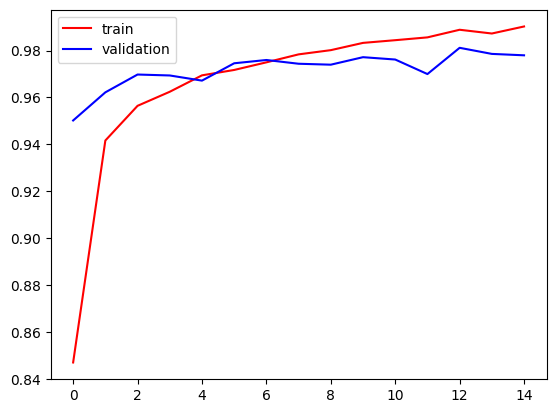

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

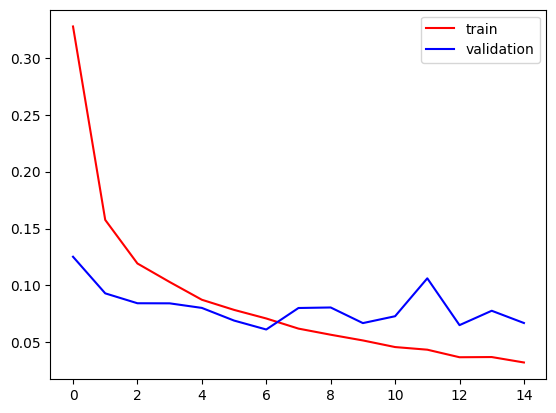

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
y_prob = model.predict(validation_ds)

157/157 [==============================] - 29s 185ms/step


In [ ]:
y_prob

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_vgg.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [47]:
model1 = load_model('model_vgg.h5')

In [48]:
img=image.load_img('/content/test/cats/cat.10001.jpg',target_size=(256,256))

In [49]:
x=image.img_to_array(img)

In [50]:
x.shape

(256, 256, 3)

In [51]:
x=x/255

In [52]:
y = model1.predict(x)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 256, 3)


In [ ]:
y = np.argmax(y)
y

0

In [45]:
img = image.load_img('/content/test/dogs/dog.10010.jpg', target_size=(256,256))
x1 = image.img_to_array(img)
x1 = x1/255
x1.shape

(256, 256, 3)

In [46]:
y1 = model1.predict(x1)
y1

InvalidArgumentError: Graph execution error:

Detected at node sequential/vgg16/block1_conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
transpose expects a vector of size 3. But input(1) is a vector of size 4
	 [[{{node sequential/vgg16/block1_conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_predict_function_53165]